In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from geopy.distance import geodesic as GD
from collections import Counter
import math
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.path as mpath
from scipy.stats import gaussian_kde
from matplotlib import cm
import pandas as pd
import matplotlib as mpl
from datetime import datetime, timedelta
import xarray as xr
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import random
from matplotlib.patches import Rectangle
from scipy.stats import ttest_ind
from plotnine import *
plt.rcParams['font.family'] = 'Times New Roman'

# A C

In [8]:
absolute_address = '../../data/RAW_DATA'
AOD_address = absolute_address + '/M2I3NXGAS_AOD_remove_leapyear.h5'
H_address = absolute_address + '/M2I3NPASM_H_remove_leapyear_season.h5'
U_address = absolute_address + '/M2I3NPASM_U_remove_leapyear_season.h5'
V_address = absolute_address + '/M2I3NPASM_V_remove_leapyear_season.h5'


f_AOD = h5py.File(AOD_address,'r')
AOD_data = f_AOD['Global'][:]
lat = f_AOD['lat'][:]
lon = f_AOD['lon'][:]
f_AOD.close()

f_H = h5py.File(H_address,'r')
H_data = f_H['H'][:]
f_H.close()

f_U = h5py.File(U_address,'r')
U_data = f_U['U'][:]
f_U.close()

f_V = h5py.File(V_address,'r')
V_data = f_V['V'][:]
f_V.close()
#-----------------------------------------------------------------------------------------------------------------

def get_event_time (data_array):

    date = np.zeros((len(data_array),))
    threshold = np.percentile(data_array,90)
    date[data_array>threshold] = 1

    tmp = date[1:] + date[:-1]
    if date[0] == 0:
        tmp = np.insert(tmp,0,0)
    else:
        tmp = np.insert(tmp,0,1)

    loc = np.arange(len(data_array))
    tmp_1 = loc[tmp == 1]

    events_time = []
    for k in range (0,len(tmp_1),2):
        time_tmp = tmp_1[k]
        events_time.append(time_tmp)
    
    return(np.array(events_time))


def EvSy_events_time(i,j,k):

    All_i_events = i
    All_j_events = j
    
    event1= len(All_i_events)
    event2= len(All_j_events)

    EvSy_i = []
    EvSy_j = []
    min_delay = []

    for i in range (1,(event1-1)):
        for j in range (1,(event2-1)):
            delay = (min (All_i_events[i+1]-All_i_events[i],All_i_events[i]-All_i_events[i-1],All_j_events[j+1]-All_j_events[j],All_j_events[j]-All_j_events[j-1]))/2
                    
            waiting_time = All_i_events[i] - All_j_events[j]

            if abs(waiting_time) <= delay and abs(waiting_time) <= k :
                EvSy_i.append(All_i_events[i])
                EvSy_j.append(All_j_events[j])
                min_delay.append(min(delay,k))

    return(EvSy_i,EvSy_j,min_delay)

#-----------------------------------------------------------------------------------------------------------------------
#stand in point i
#EvSy

def EvSy_Anormal(lat1,lon1,lat2,lon2):

    m = np.argmax(lat == lat1)
    n = np.argmax(lon == lon1)
    p = np.argmax(lat == lat2)
    q = np.argmax(lon == lon2)

    mn_AOD = np.reshape(AOD_data[...,m,n],-1)
    pq_AOD = np.reshape(AOD_data[...,p,q],-1)

    EvSy_i_events,EvSy_j_events,min_delay = EvSy_events_time(get_event_time(mn_AOD),get_event_time(pq_AOD),30)
    time_stamp = []
    for i in range (len(EvSy_i_events)):
        for j in range (int(EvSy_i_events[i]-min_delay[i]),int(EvSy_i_events[i]+min_delay[i]+1),1):
            time_stamp.append(j)

    All_days = AOD_data.shape[0]*AOD_data.shape[1]
    
    H_all = H_data.reshape((All_days,73,144))
    U_all = U_data.reshape((All_days,73,144))
    V_all = V_data.reshape((All_days,73,144))

    U_annormal = np.zeros((73,144))
    V_annormal = np.zeros((73,144))
    H_annormal = np.zeros((73,144))

    for i in range (len(time_stamp)):
        
        U_annormal += U_all[time_stamp[i],:,:]
        V_annormal += V_all[time_stamp[i],:,:]
        H_annormal += H_all[time_stamp[i],:,:]
    
    U_annormal = U_annormal/len(time_stamp)
    V_annormal = V_annormal/len(time_stamp)
    H_annormal = H_annormal/len(time_stamp)

    return(U_annormal,V_annormal,H_annormal)

# Not EvSy Annormal

def Not_EvSy_Anormal(lat1,lon1,lat2,lon2):

    m = np.argmax(lat == lat1)
    n = np.argmax(lon == lon1)
    p = np.argmax(lat == lat2)
    q = np.argmax(lon == lon2)

    mn_AOD = np.reshape(AOD_data[...,m,n],-1)
    pq_AOD = np.reshape(AOD_data[...,p,q],-1)

    All_i_events = get_event_time(mn_AOD)
    All_j_events = get_event_time(pq_AOD)
    EvSy_i_events,EvSy_j_events,min_delay = EvSy_events_time(get_event_time(mn_AOD),get_event_time(pq_AOD),30)
    Not_EvSy_i_events = np.setdiff1d(All_i_events,EvSy_i_events)
    Not_EvSy_j_events = np.setdiff1d(All_j_events,EvSy_j_events)

    min_delay = []
    can_compute_i_events = []
    for i in range (len(Not_EvSy_i_events)):
        
        closest_j_events = Not_EvSy_j_events[np.argmin(np.abs(Not_EvSy_j_events-Not_EvSy_i_events[i]))]
        i_stamp = np.argmax(All_i_events == Not_EvSy_i_events[i])
        j_stamp = np.argmax(All_j_events == closest_j_events)
        if i_stamp == len(All_i_events)-1 or j_stamp == len(All_j_events)-1:
            continue
        else:
            delay = (min (All_i_events[i_stamp+1]-All_i_events[i_stamp],All_i_events[i_stamp]-All_i_events[i_stamp-1],All_j_events[j_stamp+1]-All_j_events[j_stamp],All_j_events[j_stamp]-All_j_events[j_stamp-1]))/2
            min_delay.append(min(delay,30))
            can_compute_i_events.append(Not_EvSy_i_events[i])

    time_stamp = []
    for i in range (len(can_compute_i_events)):
        for j in range (int(can_compute_i_events[i]-min_delay[i]),int(can_compute_i_events[i]+min_delay[i]+1),1):
            time_stamp.append(j)

    All_days = AOD_data.shape[0]*AOD_data.shape[1]
    
    H_all = H_data.reshape((All_days,73,144))
    U_all = U_data.reshape((All_days,73,144))
    V_all = V_data.reshape((All_days,73,144))

    U_annormal = np.zeros((73,144))
    V_annormal = np.zeros((73,144))
    H_annormal = np.zeros((73,144))

    for i in range (len(time_stamp)):
        
        U_annormal += U_all[time_stamp[i],:,:]
        V_annormal += V_all[time_stamp[i],:,:]
        H_annormal += H_all[time_stamp[i],:,:]
    
    U_annormal = U_annormal/len(time_stamp)
    V_annormal = V_annormal/len(time_stamp)
    H_annormal = H_annormal/len(time_stamp)

    return(U_annormal,V_annormal,H_annormal)
'''
EvSy_U_Anormal,EvSy_V_Anormal,EvSy_H_Anormal = EvSy_Anormal(42.5,115,47.5,-90)
Not_EvSy_U_Anormal,Not_EvSy_V_Anormal,Not_EvSy_H_Anormal = Not_EvSy_Anormal(42.5,115,47.5,-90)

EvSy_U_Anormal,EvSy_V_Anormal,EvSy_H_Anormal = EvSy_Anormal(-40,72.5,-40,-30)
Not_EvSy_U_Anormal,Not_EvSy_V_Anormal,Not_EvSy_H_Anormal = Not_EvSy_Anormal(-40,72.5,-40,-30)
'''
EvSy_U_Anormal,EvSy_V_Anormal,EvSy_H_Anormal = EvSy_Anormal(42.5,115,47.5,-90)
Not_EvSy_U_Anormal,Not_EvSy_V_Anormal,Not_EvSy_H_Anormal = Not_EvSy_Anormal(42.5,115,47.5,-90)

In [6]:
#plot----------------

def plot_Anormal(U_Anormal,V_Anormal,H_Anormal,lat1,lon1,lat2,lon2):

    cyclic_data,cyclic_lon = add_cyclic_point(H_Anormal,coord = lon)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_axes([0.1,0.1,0.8,0.6],projection = ccrs.PlateCarree())
    ax1.add_feature(cfeature.COASTLINE.with_scale('110m'))
    gl = ax1.gridlines(draw_labels=True,x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 19}
    gl.ylabel_style = {'size': 19}
    #Hemisphere
    #South [-180,180,-90,0]
    #North [-180,180,0,90]
    ax1.set_extent([-180,180,0,90])
    ax1.plot(lon1, lat1, marker='.', color='yellow',markeredgecolor='black', markersize=25)
    ax1.plot(lon2, lat2, marker='.', color='springgreen',markeredgecolor='black', markersize=25)
    #22 30
    c1 = ax1.contourf(cyclic_lon,lat,cyclic_data,cmap=cm.coolwarm,transform = ccrs.PlateCarree(),levels = np.linspace(-22,22,20),extend = 'both')
    colorbar = fig.add_axes([0.93,0.25,0.01,0.3])
    cbar = fig.colorbar(c1,cax=colorbar,format = '%d') 
    cbar.ax.tick_params(labelsize=19)
    cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator(8))
    c1.set_rasterized(True)

    q1=ax1.quiver(lon[::2],lat[::2],U_Anormal[::2,::2],V_Anormal[::2,::2],width=0.001,scale=60,transform=ccrs.PlateCarree(),color='black')
    ax1.quiverkey(q1, 0.95, 1.2, 3, 'winspeed=3m/s', labelpos='S',coordinates='axes',fontproperties={'size': 15})
    ax1.set_title(' \n \n ')
    #fig.savefig('../image/fig4d.svg',dpi = 500,bbox_inches='tight') 
    plt.show()

C:\Users\34322\AppData\Local\Temp\ipykernel_18860\3051375886.py:26: UserWarning: Rasterization of '<cartopy.mpl.contour.GeoContourSet object at 0x000001CDE662CB10>' will be ignored


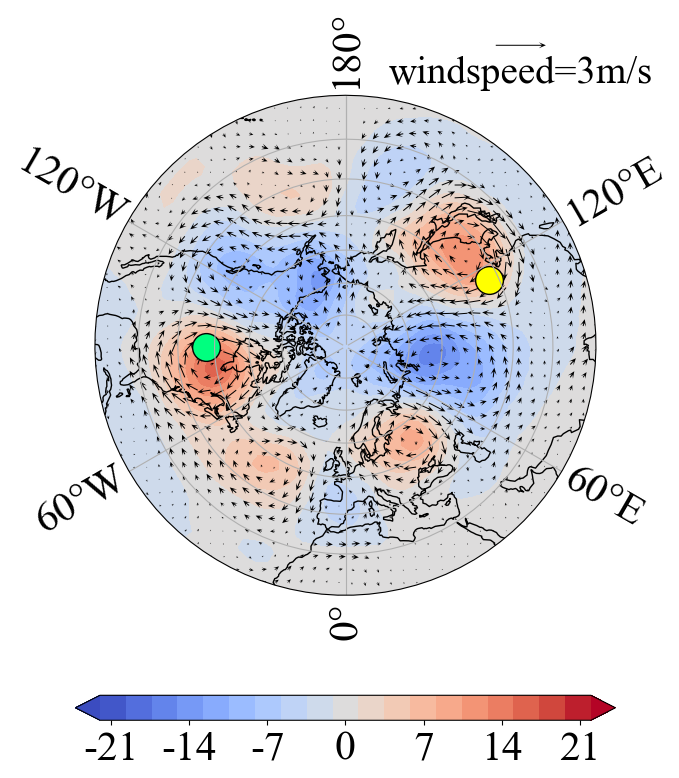

In [14]:
cyclic_data,cyclic_lon = add_cyclic_point(EvSy_H_Anormal,coord = lon)
#cyclic_data,cyclic_lon = add_cyclic_point(Not_EvSy_H_Anormal,coord = lon)

fig = plt.figure(figsize=(6,5))

plt.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams["font.size"] = 20

ax1 = fig.add_axes([0,0,1,1],projection = ccrs.NorthPolarStereo())
#ax1 = fig.add_axes([0,0,1,1],projection = ccrs.SouthPolarStereo())
ax1.set_extent([-180, 180, 20, 90], ccrs.PlateCarree())
#ax1.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
ax1.add_feature(cfeature.COASTLINE.with_scale('110m'))
gl1 = ax1.gridlines(draw_labels=True,x_inline=False, y_inline=False)
gl1.xlabel_style = {'size': 30}
gl1.ylabel_style = {'size': 30}
c1 = ax1.contourf(cyclic_lon,lat,cyclic_data,cmap=cm.coolwarm,levels = np.linspace(-22,22,20),extend = 'both',transform = ccrs.PlateCarree())
colorbar = fig.add_axes([0.05,-0.25,0.9,0.05])
cbar1 = fig.colorbar(c1,cax=colorbar,orientation='horizontal',format = '%d',ticks=[-21,-14,-7,0,7,14,21]) 
cbar1.ax.tick_params(labelsize=30)
c1.set_rasterized(True)

#q1=ax1.quiver(lon,lat,Not_EvSy_U_Anormal,Not_EvSy_V_Anormal,width=0.002,scale=30,regrid_shape = 40,transform=ccrs.PlateCarree(),color='black',headwidth=6,headlength = 7,headaxislength = 4)
q1=ax1.quiver(lon,lat,EvSy_U_Anormal,EvSy_V_Anormal,width=0.002,scale=30,regrid_shape = 40,transform=ccrs.PlateCarree(),color='black',headwidth=6,headlength = 7,headaxislength = 4)
ax1.quiverkey(q1, 0.85, 1.1, 3, 'windspeed=3m/s', labelpos='S',coordinates='axes',fontproperties={'size': 28})
#ax1.quiverkey(q1, 0.9, 1.05, 3, 'windspeed=3m/s', labelpos='S',coordinates='axes',fontproperties={'size': 18})

#42.5,115    47.5,-90 
#-40,72.5   -40,-30
ax1.plot(115, 42.5, marker='.', color='yellow',markeredgecolor='black', markersize=40,transform = ccrs.PlateCarree())
ax1.plot(-90, 47.5, marker='.', color='springgreen',markeredgecolor='black', markersize=40,transform = ccrs.PlateCarree())
plt.savefig("FIG/FIG4/FIGS4a.svg", bbox_inches='tight', dpi=400, transparent=True)
plt.show()

# E F G H

In [ ]:
real_address = '../../data/Same_ET_ST_result/Network3_SC.h5'

f_real = h5py.File(real_address,'r')
SC = f_real['SC'][:]
asy = f_real['asy'][:]
dis = f_real['dis'][:]
lat = f_real['lat'][:]
lon = f_real['lon'][:]
f_real.close()

degree = np.zeros((73,144))

for m in range (0,73,1):
    for n in range (0,144,1):

        degree_value = 0

        for p in range (0,73,1):
            for q in range (0,144,1):
                if SC[m,n,p,q] == 0:
                    continue
                else:
                    if dis[m,n,p,q]>5000:
                        degree_value += abs(SC[m,n,p,q]*np.cos(lat[p]*np.pi/180))
                    else:
                        continue
        degree[m,n] = degree_value

degree_north = []
degree_south = []

for i in range (36,len(lat),1):
    for j in range (0,len(lon),1):
        degree_north.append({'lat':lat[i],'lon':lon[j],'degree':degree[i][j]})

degree_north_df = pd.DataFrame(degree_north)
degree_north_ds = xr.Dataset.from_dataframe(degree_north_df.set_index(['lat', 'lon']))

for i in range (0,37,1):
    for j in range (0,144,1):
        degree_south.append({'lat':lat[i],'lon':lon[j],'degree':degree[i][j]})

degree_south_df = pd.DataFrame(degree_south)
degree_south_ds = xr.Dataset.from_dataframe(degree_south_df.set_index(['lat', 'lon']))

In [ ]:
data_north = degree_north_ds['degree']
lat_north = data_north.lat
lon_north = data_north.lon


cyclic_data_north,cyclic_lon_north = add_cyclic_point(data_north,coord=lon_north)

fig = plt.figure(figsize=(6,5))

plt.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams["font.size"] = 20

ax1 = fig.add_axes([0,0,1,1],projection = ccrs.NorthPolarStereo())
ax1.set_extent([-180, 180, 0, 90], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
ax1.add_feature(cfeature.COASTLINE.with_scale('110m'))
gl1 = ax1.gridlines(draw_labels=True,x_inline=False, y_inline=False)
c1 = ax1.contourf(cyclic_lon_north,lat_north,cyclic_data_north,cmap=cm.YlGnBu,levels = np.linspace(0,500,10),extend = 'max',transform = ccrs.PlateCarree())
colorbar = fig.add_axes([0.99,-0.05,0.03,1.1])
cbar1 = fig.colorbar(c1,cax=colorbar,format = '%d') 
cbar1.ax.tick_params(labelsize=20)
c1.set_rasterized(True)
plt.savefig("FIG/FIG4/FIG4f.svg", bbox_inches='tight', dpi=400, transparent=True)
plt.show()
#fig.savefig('../image/fig5b.svg',dpi = 750,bbox_inches='tight') 

In [ ]:
data_south = degree_south_ds['degree']
lat_south = data_south.lat
lon_south = data_south.lon
cyclic_data_south,cyclic_lon_south = add_cyclic_point(data_south,coord=lon_south)

fig = plt.figure(figsize=(6,5))

plt.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams["font.size"] = 20

ax1 = fig.add_axes([0,0,1,1],projection = ccrs.SouthPolarStereo())
ax1.set_extent([-180, 180, -90, 0], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
ax1.add_feature(cfeature.COASTLINE.with_scale('110m'))
gl1 = ax1.gridlines(draw_labels=True,x_inline=False, y_inline=False)
c1 = ax1.contourf(cyclic_lon_south,lat_south,cyclic_data_south,cmap=cm.YlGnBu,levels = np.linspace(0,700,10),extend = 'max',transform = ccrs.PlateCarree())
colorbar = fig.add_axes([0.99,-0.05,0.03,1.1])
cbar1 = fig.colorbar(c1,cax=colorbar,format = '%d') 
cbar1.ax.tick_params(labelsize=20)
c1.set_rasterized(True)
plt.savefig("FIG/FIG4/FIG4h.svg", bbox_inches='tight', dpi=400, transparent=True)
plt.show()

#fig.savefig('../image/fig5e.svg',dpi = 750,bbox_inches='tight') 